<a href="https://colab.research.google.com/github/enricco000/MR4010.10/blob/main/Actividad_4_2_Clasificaci%C3%B3n_CNN_GTRSB_Equipo19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Maestría en Inteligencia Artificial Aplicada

### Curso: Navegación Autónoma

### Tecnológico de Monterrey
#### Profesor Titular: 	Dr. David Antonio Torres
#### Profesor Tutor: Mtra: Maricarmen Vázquez Rojí

### Actividad 4.2 - Detección de Señales de Tránsito

#### Integrantes:

* Aguilar Pérez, Elber Manuel-  A01793568
* Enrique Hernández García -  A01793727
* Fredy Reyes Sánchez - A01687370
* Marco Antonio Vázquez Morales - A01793704

In [ ]:
# importamos las librerias a utilizar en la construcción del modelo 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
import random
     
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
     
from keras.models import Model

In [ ]:
# Al igual que en la actividad anterior, el dataset está en google drive.
# Para correr este notebook, debes subir tu
# dataset a google drive también. En la entrega anterior, utilizamos el juego
# el siguiente juego de datos de Kaggle:
# https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign?resource=download
# Para poder accederlo desde este notebook
# necesitamos importar drive
from google.colab import drive
drive.mount('/content/drive')
# Definimos la ruta de la carpeta donde se encuentran las imágenes
PWD = '/content/drive/MyDrive/Navegacion Autonoma/gtsrb'
# Definimos las rutas de las subcarpetas
train_path = os.path.join(PWD, 'Train')
test_path = os.path.join(PWD, 'Test')
meta_path = os.path.join(PWD, 'Meta')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Definimos las variables de alto y ancho de las images y sus canales, en este caso 30 x 30 y RGB
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [ ]:
#obtenemos el total de las clases o categorías dentro del dataset

NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [ ]:
# Definimos los labels para las 43 clases en el dataset

classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

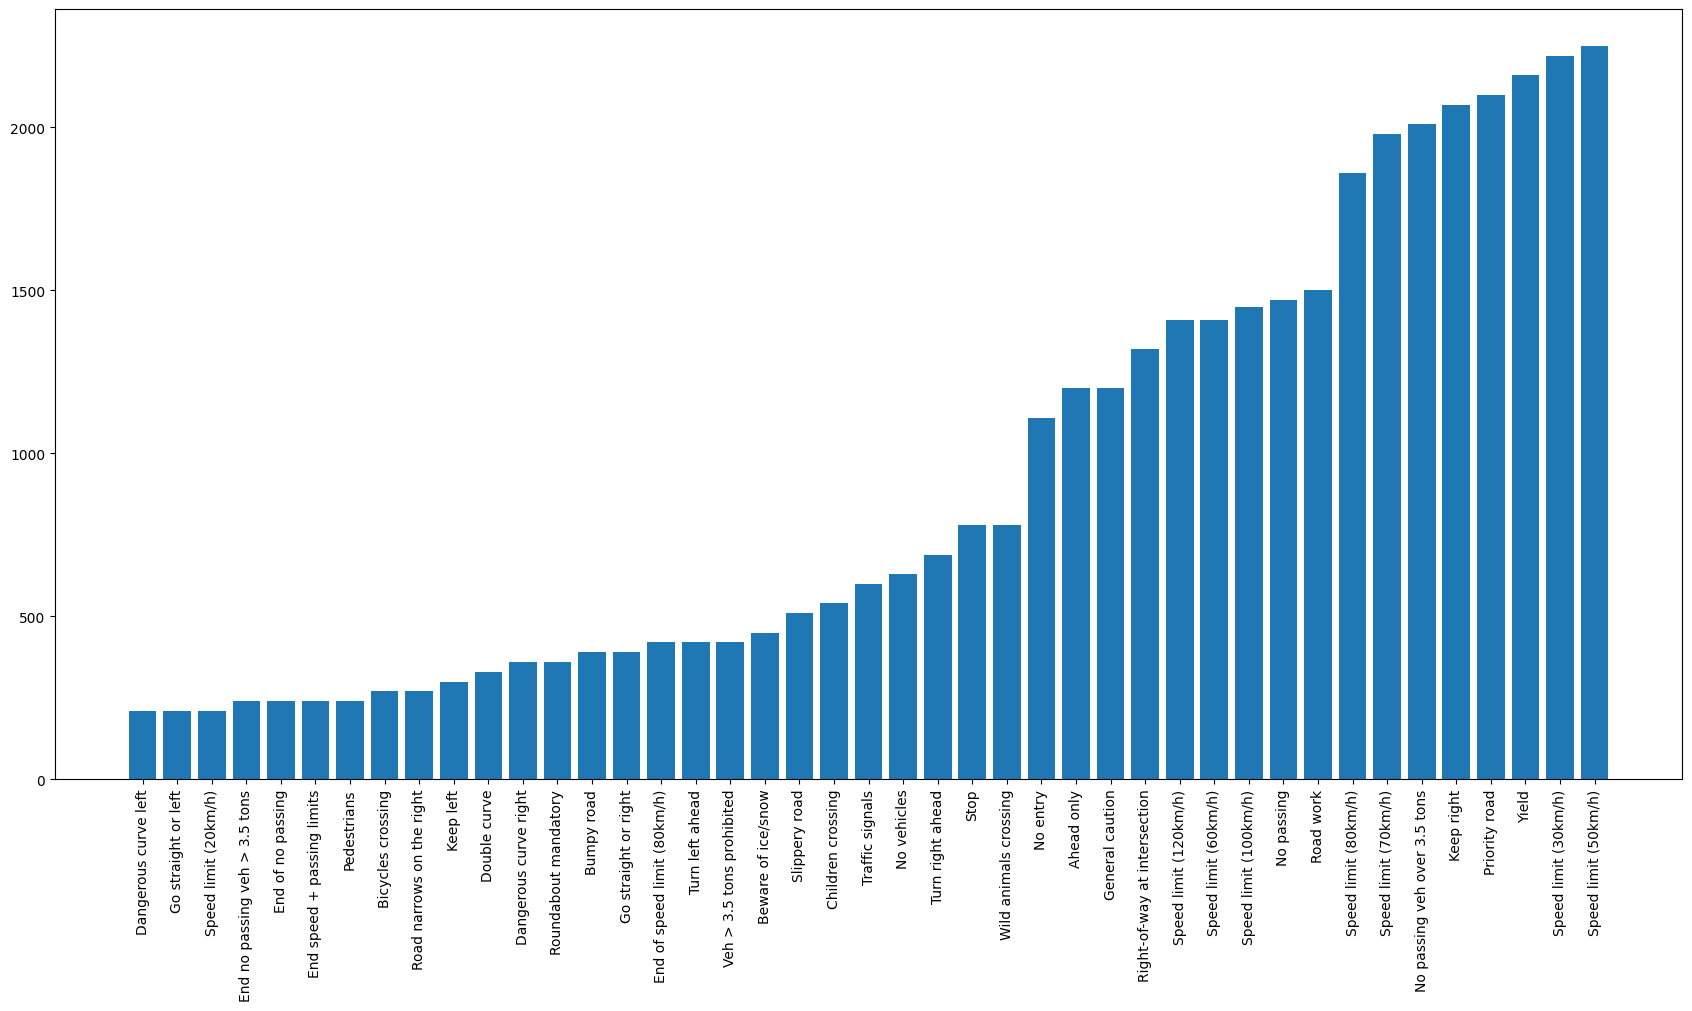

In [ ]:
#visualizamos la composición del dataset, de acuerdo con los labels asociados a cada clase

folders = os.listdir(train_path)

train_number = []
class_num = []

# recorremos con el ciclo for la ruta de nuestro set de entrenamiento

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Clasificación del conjunto de datos en función del número de imágenes de cada clase
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Mostramos el número de imágenes por cada una de nuestras clases

plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

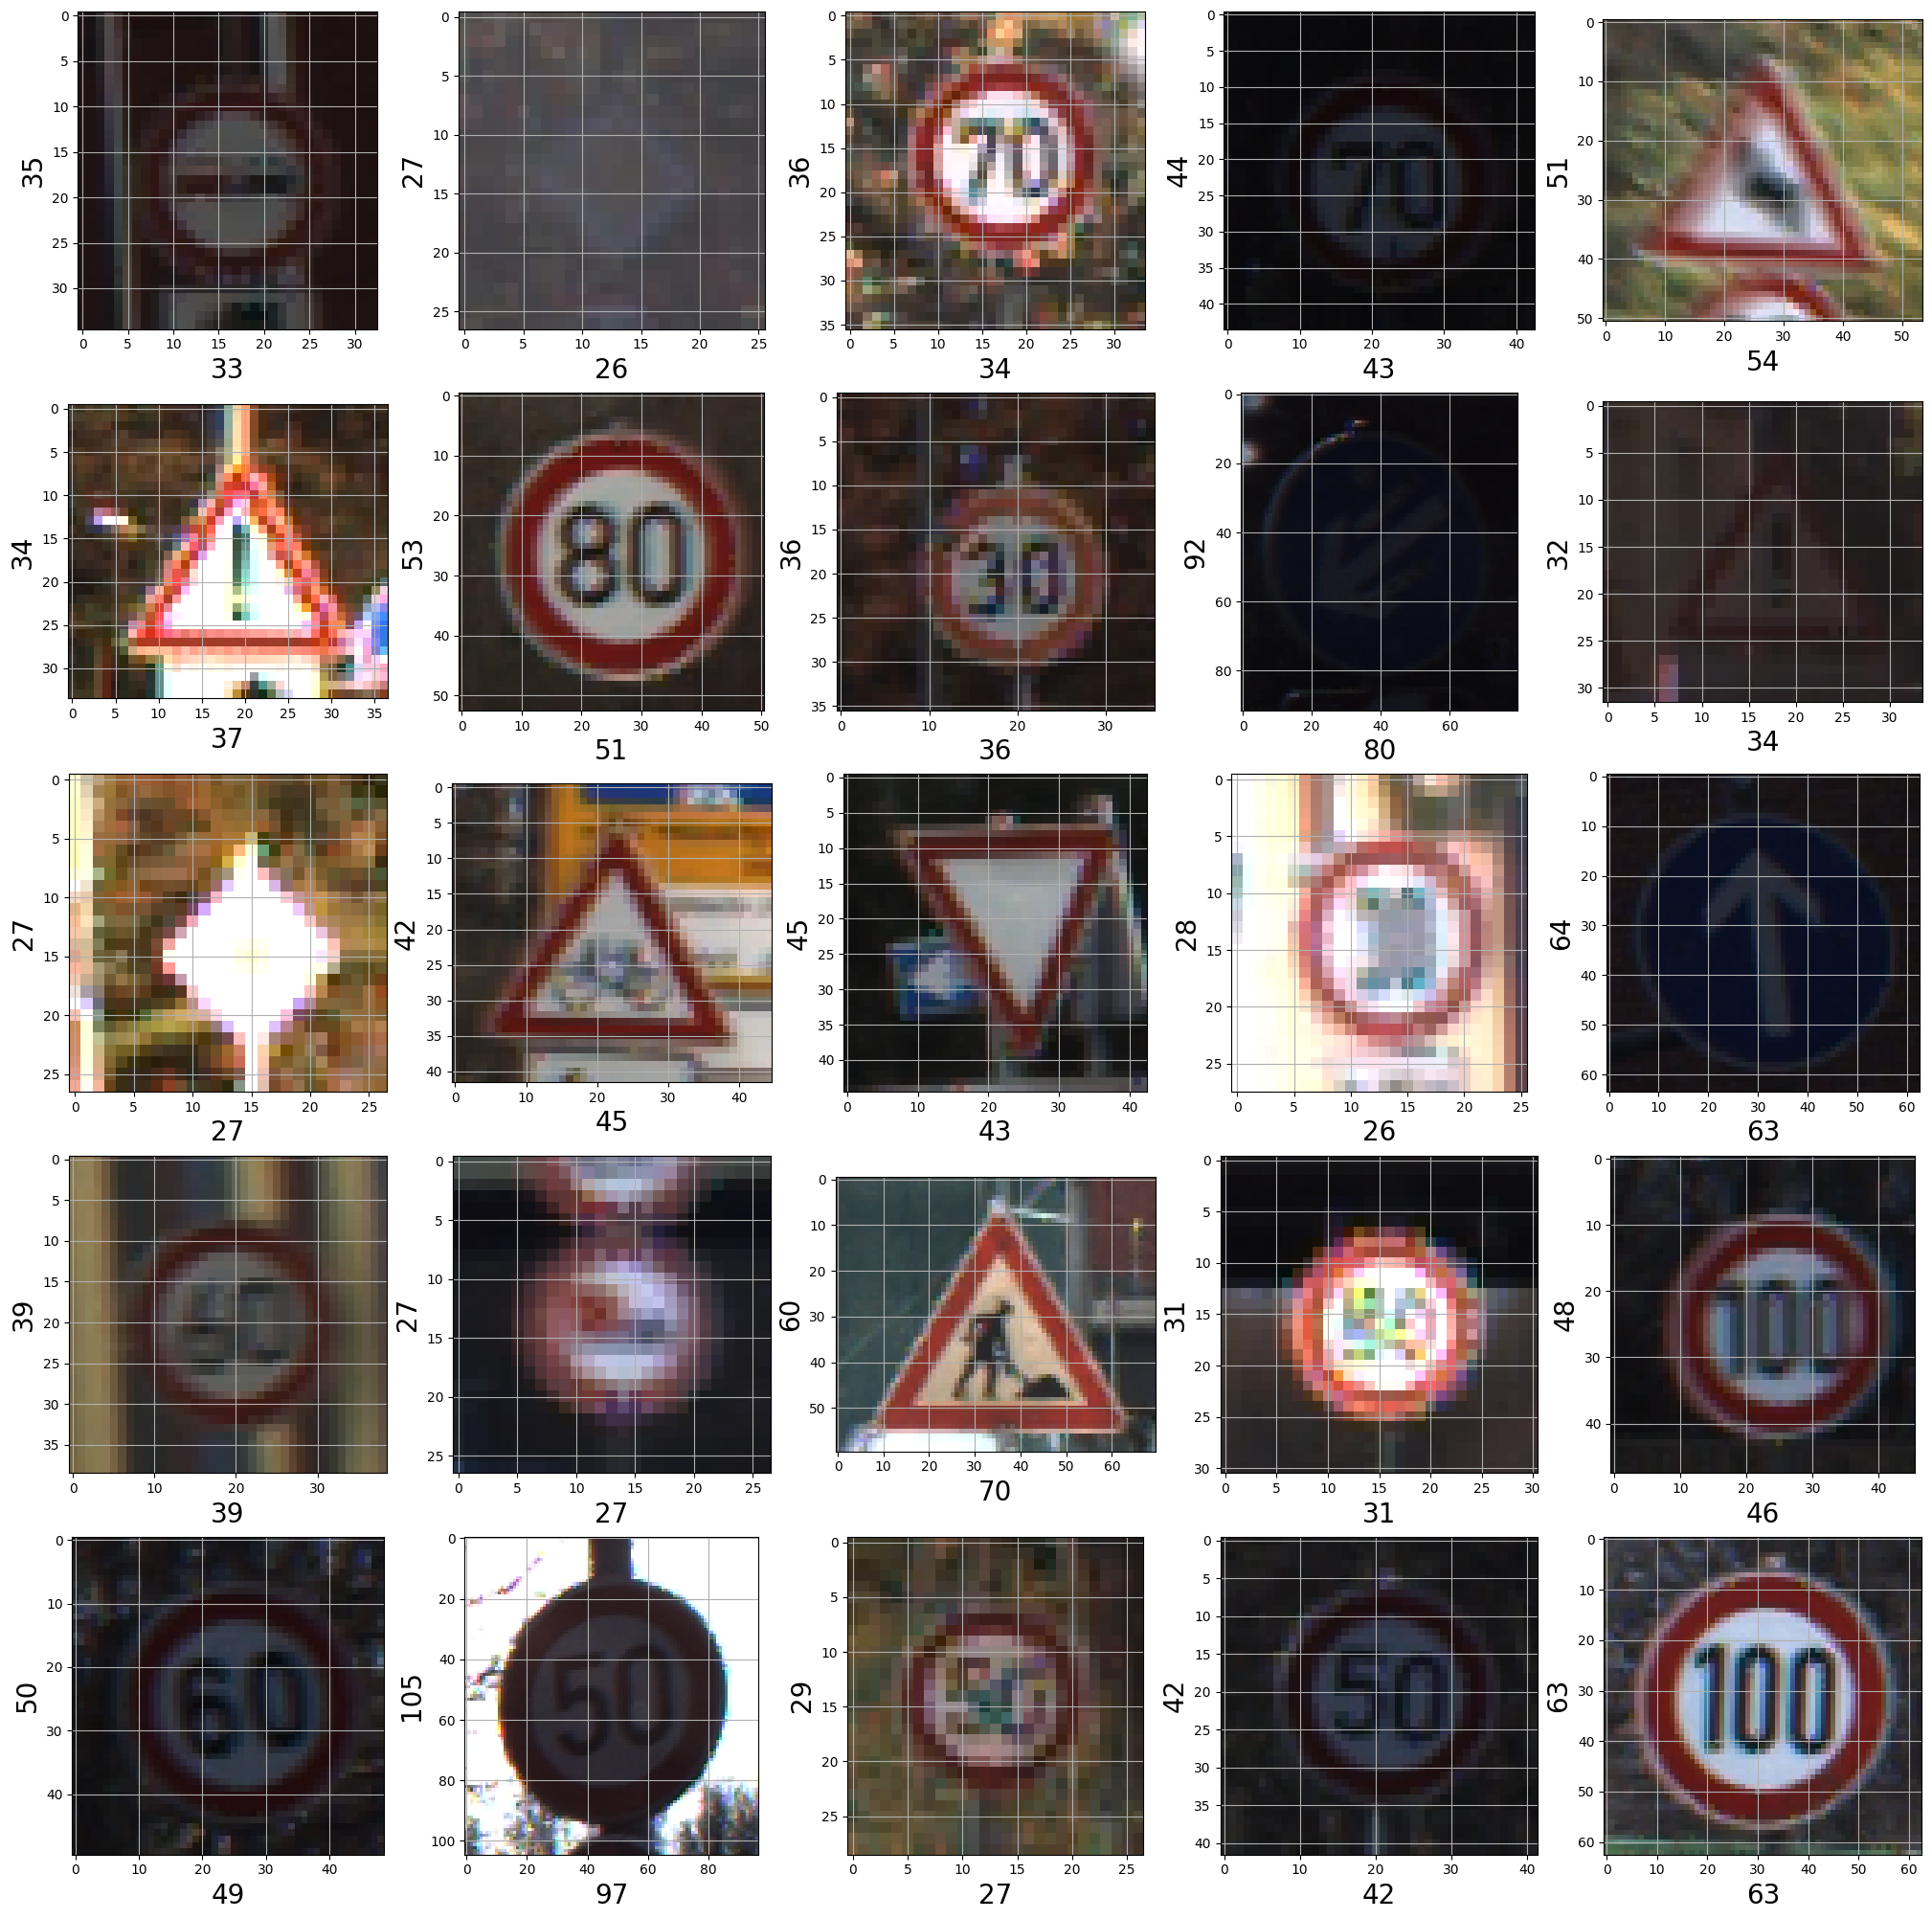

In [ ]:
# Cargamos una muestra de 25 imágenes de nuestros datos de prueba 

import random
from matplotlib.image import imread

# cargamos el archivo csv con la relación de las imágenes de prueba, este archivo hace de nuestro diccionario de indexación del dataset
test = pd.read_csv(PWD + '/Test.csv')
imgs = test["Path"].values

# definimos el tamaño de las figuras 25 X 25
plt.figure(figsize=(25,25))

# ejecutamos ciclo for para obtener 25 imágenes random del dataset de pruebas
for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = PWD + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid()
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

In [ ]:
#realizamos la transformación de nuestros datos de entrenamiento
# 1. leemos cada una de las imagenes en el directorio Train
# 2. convertimos nuestra imágenes a formato RGB para luego agregarlas a la lista image_data
# 3. Ajustamos el tamaño de nuestras imágenes de entrenamiento al tamaño definido anteriormente 30 x 30
# 4. Transformamos las listas de image_data y image_label a un array en numpy

image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = PWD + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39219, 30, 30, 3) (39219,)


In [ ]:
#Shuffle the training data
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [ ]:
# dividimos los datos utilizando la libreria train_test_split de sklearn, dejando un 30% para pruebas 

from sklearn.model_selection import train_test_split
#split train and test data
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

# X_train = X_train/255 
# X_val = X_val/255

# imprimimos la distribución de nuestros set de entrenamiento y validación

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27453, 30, 30, 3)
X_valid.shape (11766, 30, 30, 3)
y_train.shape (27453,)
y_valid.shape (11766,)


In [ ]:
#One-hot encoding para nuestros set de datos, en nuestro caso para las 43 labels antes definidos

y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27453, 43)
(11766, 43)


In [ ]:
#definimos nuestro modelo que estara conformado:
# 4 capas convolucionales, una capa MaxPool2D al final de cada capa convulucional, para este caso no definimos padding como parametros de entrada
# BatchNormalization para disminuir los tiempos de entrenamiento de nuestra CNN
# una capa flatten con 512 neuronas, y una capa densa que recibe como párametro nuestras 43 clases en nuestros data sets de entrenamiento y pruebas

model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)), 
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

In [ ]:
# definimos 25 epochs para nuestra CNN
epochs = 25
# dejamos los mismos parámetros utilizados en el ejemplo del maestro lr = 0.001, como función de perdida categorical_crossentropy
# y nuestra métrica la exactitud
model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 13, 13, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 9, 128)         7

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# para realiza el entrenamiento de nuestra CNN implementamos la técnica de data augmentation que nos va a permitir
# pasarle a nuestra red las imágenes con una mayor cantidad de variaciones en cuanto a profudidad, angulos, etc.

from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/25
858/858 [==============================] - 39s 33ms/step - loss: 1.0957 - accuracy: 0.6995 - val_loss: 0.1537 - val_accuracy: 0.9543
Epoch 2/25
858/858 [==============================] - 20s 23ms/step - loss: 0.2278 - accuracy: 0.9317 - val_loss: 0.0405 - val_accuracy: 0.9888
Epoch 3/25
858/858 [==============================] - 22s 25ms/step - loss: 0.1280 - accuracy: 0.9602 - val_loss: 0.0465 - val_accuracy: 0.9861
Epoch 4/25
858/858 [==============================] - 22s 25ms/step - loss: 0.0999 - accuracy: 0.9698 - val_loss: 0.0230 - val_accuracy: 0.9942
Epoch 5/25
858/858 [==============================] - 22s 25ms/step - loss: 0.0843 - accuracy: 0.9748 - val_loss: 0.0261 - val_accuracy: 0.9923
Epoch 6/25
858/858 [==============================] - 20s 23ms/step - loss: 0.0776 - accuracy: 0.9768 - val_loss: 0.0321 - val_accuracy: 0.9890
Epoch 7/25
858/858 [==============================] - 21s 25ms/step - loss: 0.0699 - accuracy: 0.9793 - val_loss: 0.0150 - val_accuracy:

<function matplotlib.pyplot.show(close=None, block=None)>

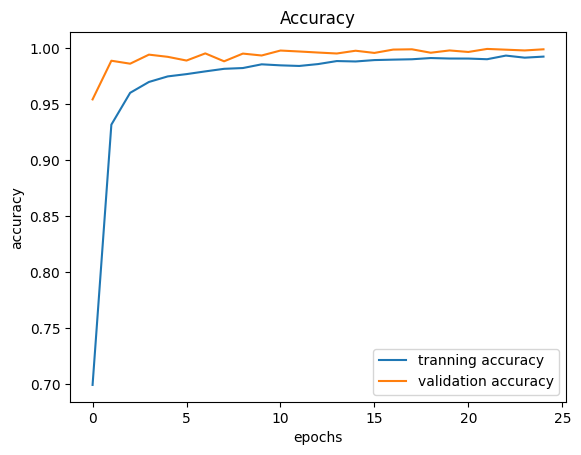

In [ ]:
# generamos nuestra gráfica con el accuracy de nuestros dos data set entrenamiento vs validación 

plt.figure(0)
plt.plot(history.history['accuracy'],label='tranning accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

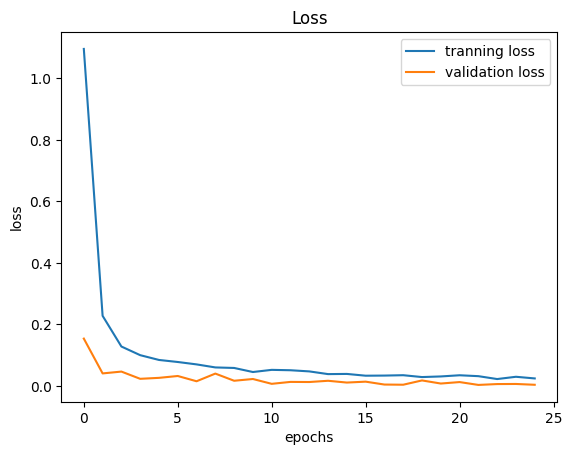

In [ ]:
# generamos nuestra gráfica de perdida de nuestro datos de entrenamiento vs validación

plt.plot(history.history['loss'],label='tranning loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show

In [ ]:
# cargamos nuestros datos de prueba para validar el accuracy obtenido durante el entrenamiento sea correcto
# para esto aplicamos sobre el set datos las transformaciones antes descritas para nuestros set de entrenamiento.
# 1. leemos cada una de las imagenes en el directorio test
# 2. convertimos nuestra imágenes a formato RGB para luego agregarlas a la lista image_data
# 3. Ajustamos el tamaño de nuestras imágenes de pruebas al tamaño definido anteriormente 30 x 30

from sklearn.metrics import accuracy_score

test = pd.read_csv(PWD + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(PWD + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
# X_test = X_test/255


predict_x=model.predict(X_test) 
pred=np.argmax(predict_x,axis=1)



#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

395/395 [==============================] - 1s 2ms/step
Test Data accuracy:  98.31353919239905


In [ ]:
# obtenemos el reporte de clasifación utilizando la función classification_report de sklearn para cada una de nuestras 43 clases
# precisión, recall, f1-score

from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.99      1.00      0.99       720
           2       0.99      1.00      1.00       750
           3       0.99      0.95      0.97       450
           4       1.00      0.99      1.00       660
           5       0.96      0.99      0.97       630
           6       0.99      0.98      0.99       150
           7       1.00      1.00      1.00       450
           8       0.99      1.00      0.99       450
           9       0.99      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.99      0.97      0.98       420
          12       1.00      1.00      1.00       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.99      1.00      1.00       210
          16       1.00      0.99      1.00       150
          17       1.00    

In [ ]:
# validamos nuestro modelo 

from PIL import Image

# función para realizar las tranformaciones antes mencionadas sobre los imput que recibe el modelo

def predict_Image(img):
    data=[]
    image=Image.open(img).resize((30,30))
    data.append(np.array(image))
    X_test = np.array(data)
    
    predict_x=model.predict(X_test) 
    Y_pred=np.argmax(predict_x,axis=1)
    return image,Y_pred

1/1 [==============================] - 0s 137ms/step

Predicted:  Speed limit (60km/h)


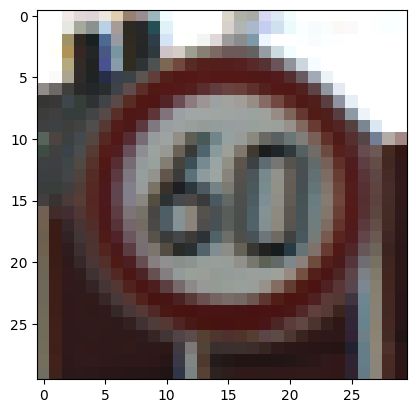

In [ ]:
plot,prediction = predict_Image(PWD+'/Test/00115.png')
print("\nPredicted: " ,classes[prediction.item()]) #item() converts numpy int64 to native int
plt.imshow(plot)
plt.show()

### Conclusiones 

- Se llevaron a cabo multiples pruebas de pre-procesamiento sobre las imágenes del dataset, y se determinó que entre mayor el número de pixeles a los cuales se ajustaba la imagen, disminuía la precisión del modelo, se realizarón pruebas con tamaños (64x64, 40x40 y 30x30) siendo este último el de mejor resultado 98%.

- Dentro de la investigación realizada, se agrega una nueva capa a la red convolucional BatchNormalization, La normalización por lotes es una técnica para entrenar redes neuronales muy profundas que estandariza las entradas a una capa para cada mini-lote. Esto tiene el efecto de estabilizar el proceso de aprendizaje y reducir dramáticamente el número de épocas de entrenamiento requeridas para entrenar redes profundas.

### Bibliografía 

- Kaggle, GTSRB - German Traffic Sign Recognition Benchmark. Recuperado, 11 de junio de 2023, https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/code

- Keras, MaxPooling2D layer, Recuperado, 11 de junio de 2023, https://keras.io/api/layers/pooling_layers/max_pooling2d/

- Towars Data Science, Batch Normalization in practice: an example with Keras and TensorFlow 2.0. Recuperado, 11 de junio de 2023, https://towardsdatascience.com/batch-normalization-in-practice-an-example-with-keras-and-tensorflow-2-0-b1ec28bde96f
